In [1]:
from mahotas.features import surf
from sklearn.neighbors import NearestNeighbors
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from skimage.transform import resize
import glob, os
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

In [2]:
def find_surf(img):
    # returns the list of SURF descriptors for the image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = resize(img, (320, 240))
    spoints = surf.surf(img, descriptor_only=True, nr_octaves=4, nr_scales=5, initial_step_size=1, threshold=1e-8, max_points=1024)
    descrs = spoints
    return descrs

# Compute features for every image

In [3]:
test_data = np.loadtxt('TestSet.txt', delimiter = '\n')
train_data = np.loadtxt('NewData.txt', delimiter = '\n')
test_data = ['images/' + str(int(x))+ '.jpg' for x in test_data]
train_data = ['images/' + str(int(x))+ '.jpg' for x in train_data]

In [4]:
list_files = []
image_features = []
features_list = []

# Compute SURF features for every picture in the train dataset
for file in tqdm(train_data):
        features = find_surf(cv2.imread(file))
        for feature in features:
            features_list.append(feature)
        list_files.append(file)
        image_features.append(features)

limit = len(list_files)

# Make clusters for visual bag of words

In [5]:
n_clusters = 200

# Clusterize all the features found in the train dataset to create a visual word vocabulary
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features_list)

In [6]:
feature_vocab = kmeans.cluster_centers_
num_words = feature_vocab.shape[0]

In [7]:
from sklearn.neighbors import KDTree

# Use KD tree to retrieve the closest visual words more efficiently

def closest_word_vocab(feature_vocab):
    tree = KDTree(feature_vocab, leaf_size=1000)     
    return tree

tree_vocab = closest_word_vocab(feature_vocab)

In [8]:
list_hist = np.zeros((limit, n_clusters))

# For each image in the train dataset, we build a histogram of the occurrence of each visual word
# by assigning the closest visual word to each SURF feature of the image

for i in range (limit):
        descrs = image_features[i]
        dist, ind = tree_vocab.query(descrs, k=1)
        hist = np.zeros(num_words)
        unique_words, count_words = np.unique(ind, return_counts=True)
        hist[unique_words] = count_words
        list_hist[i,:] = hist
      

    
    
# We use TF-IDF weighting to improve search results
        
idf = np.sum(list_hist > 0, axis=0)
idf = np.log(limit / idf)

list_hist = list_hist * idf
list_hist = np.sqrt(list_hist)
list_hist = (list_hist.T / np.linalg.norm(list_hist, axis = 1)).T

# Search

In [13]:
def matching_score(query_hist):
    # computes the similarity scores between the query image and all images in the train dataset
    scores = np.zeros((1,limit))
    for i in range (limit):
        scores[0,i] = np.dot(query_hist, list_hist[i])
    return scores

def search(img_name):
    # Search for and plot the 5 closest images to the query image
    query_img = cv2.imread(img_name)
    
    # compute SURF feaures
    descrs = find_surf(query_img)
    _, indexes = tree_vocab.query(descrs, k=1)
    query_hist = np.zeros(num_words)
    unique_words, count_words = np.unique(indexes, return_counts=True)
    
    # process histogram of visual words
    query_hist[unique_words] = count_words
    query_hist = query_hist * idf
    query_hist = np.sqrt(query_hist)
    query_hist = query_hist / np.linalg.norm(query_hist)

    scores = matching_score(query_hist)
    
    # sort in descending order
    scores_sorted_idx = np.argsort(-scores)
    scores_sorted = scores.ravel()[scores_sorted_idx]
    
    # plot top matches
    N=5
    top_N_idx = scores_sorted_idx.ravel()[:N]

    plt.figure()
    plt.figure(figsize= (20,5))
    plt.subplot(1,N+1,1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title('Original image')
    for i in range(N):

        file = list_files[top_N_idx[i]]    
        img = cv2.imread(file)
        # choose subplot
        plt.subplot(1,N+1,i+2)
        # plot
        plt.imshow(img)
        plt.title('Nearest image -'+str(i+1))

<Figure size 432x288 with 0 Axes>

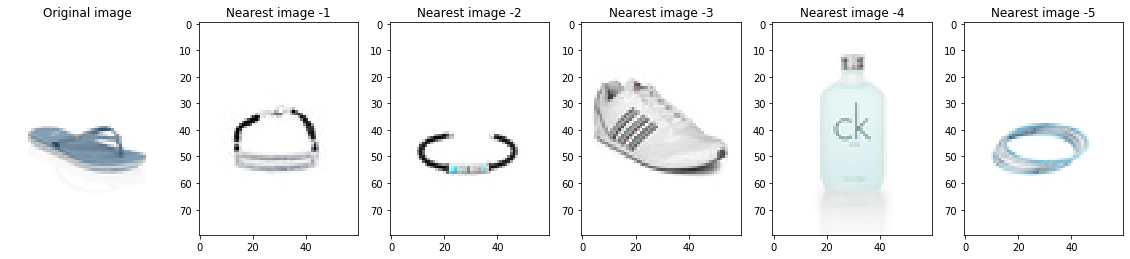

<Figure size 432x288 with 0 Axes>

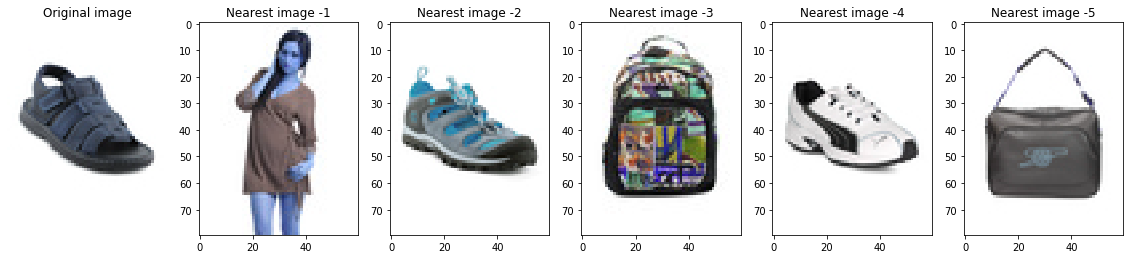

<Figure size 432x288 with 0 Axes>

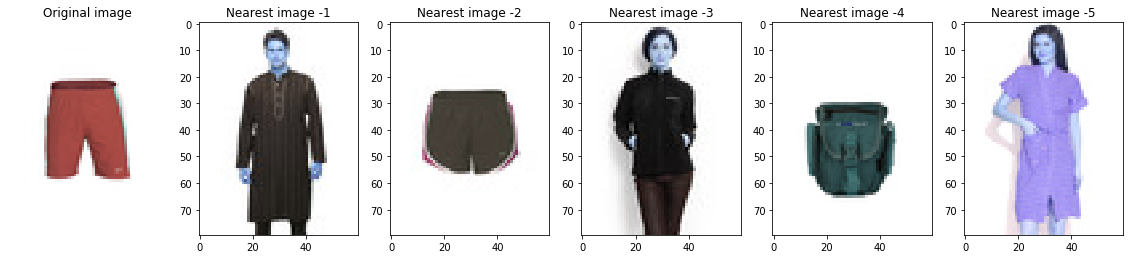

<Figure size 432x288 with 0 Axes>

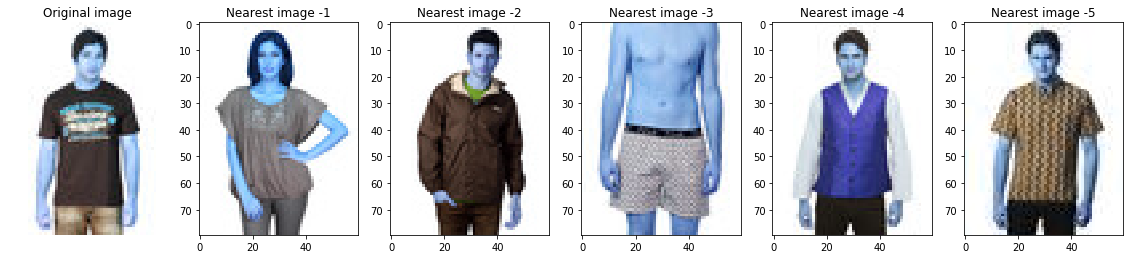

<Figure size 432x288 with 0 Axes>

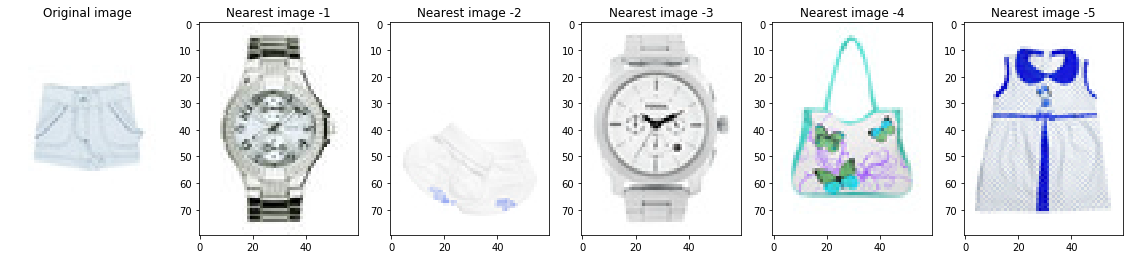

<Figure size 432x288 with 0 Axes>

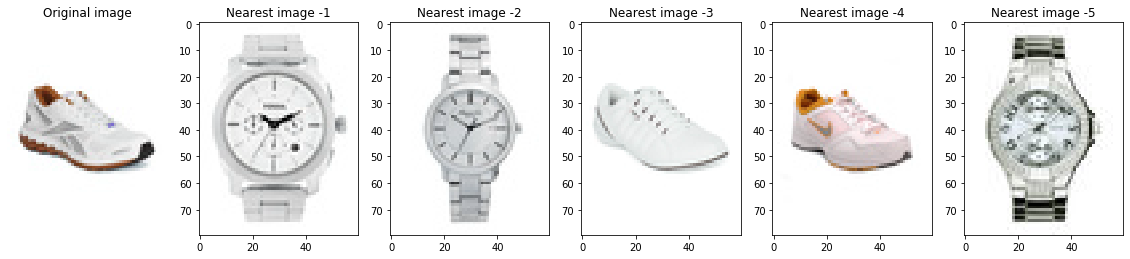

<Figure size 432x288 with 0 Axes>

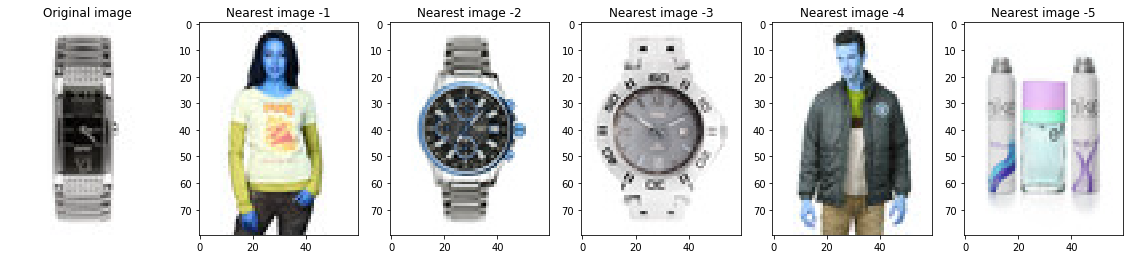

<Figure size 432x288 with 0 Axes>

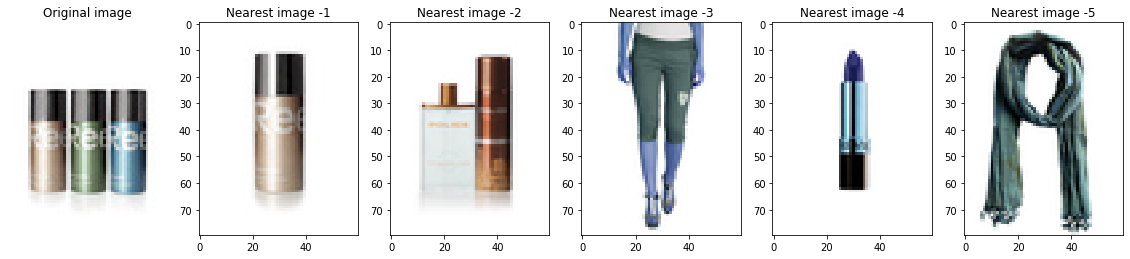

<Figure size 432x288 with 0 Axes>

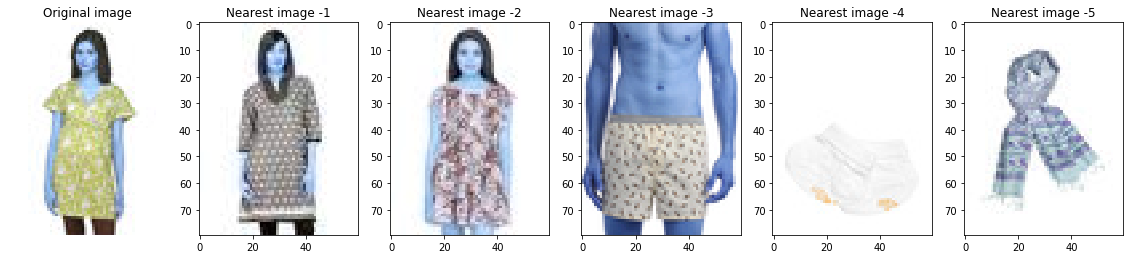

<Figure size 432x288 with 0 Axes>

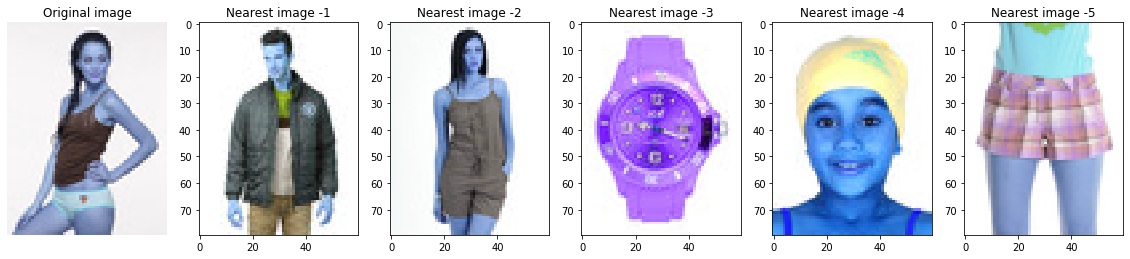

In [14]:
for test in tqdm(test_data):
    search(test)

In [ ]:
def find_img_cosine(path_img_1, path_img_2):
    # Returns cosine similarity between two images
    img1 = cv2.imread(path_img_1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = np.reshape(img1,(len(img1)*len(img1[0]),1))
    img1 = [x[0] for x in img1]
    
    img2 = cv2.imread(path_img_2)
    img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = np.reshape(img2,(len(img2)*len(img2[0]),1))
    img2 = [x[0] for x in img2]
    
    try:
        return [cosine_similarity([img1],[img2])[0][0]]
    except:
        print ("Different Dimensions, return empty array")
        return []